<a href="https://colab.research.google.com/github/jborovicka/nyu-phd-macro-i/blob/main/jupyter/mccall_value_function_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value function iteration in the McCall (1970) model

<b>This notebook is based on Sections 22-24 from the <a href="https://python.quantecon.org/">Quantitative Economics with Python</a> lecture.</b> <i>The code in this notebook is simplified and abstracts from classes or just-in-time compiling for transparency reasons. The QuantEcon lectures provide further instructions how to accelerate the code, and utilize the Python functionality in much more depth.</i>

We study the problem of a worker who receives wage offers $w$ drawn from a distribution $F(w)$. Denote $V(w)$ the value of an unemployed worker with offer $w$ at hand. Then $V$ satisfies the Bellman equation

$$V\left( w\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta} ,c+\beta \int_{0}^{B}V\left( w^{\prime }\right)
dF\left( w^{\prime }\right) \right\} .$$

This can be succintly written as the fixed-point equation $V=TV$ where $T$ is the Bellman operator defined as

$$(Th)\left( w\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta} ,c+\beta \int_{0}^{B}h\left( w^{\prime }\right)
dF\left( w^{\prime }\right) \right\} .$$

Implementing the problem on a computer requires several considerations.

<ol>
    <li>We need to evaluate the integral on the right-hand side of the Bellman equation. When the distribution of offers is discrete with finitely many mass points, then the integral can be replaced with a finite sum, otherwise we need to rely on an approximation.</li>
    <li>We need to replace the function $V$ defined on the interval $[0,B]$ with a its approximation defined on a finite grid of nodes. Again, if the distribution of offers is discrete with finitely many mass points, then these mass points can serve as the nodes, since no other offers can be made anyway.</li>
    <li>We need to provide an argument that the method will converge to the correct unique solution. In our case, this is guaranteed by the Banach fixed point theorem, which can be invoked for our problem.</li>
</ol>

## The algorithm

The <b>value function iteration</b> algorithm is given by the following scheme.

<ol>
    <li>Pick an initial guess for the value function, denoted $V_0$.</li>
    <li>Given the $n$-th iteration guess $V_n$, update it as
    \begin{equation}
        V_{n+1}\left( w\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
        \frac{w}{1-\beta} ,c+\beta \int_{0}^{B}V_n\left( w^{\prime }\right)
        dF\left( w^{\prime }\right) \right\}.
    \end{equation}
    </li>
    <li>Repeat step 2 until $|V_{n+1}-V_n|$ falls below a given precision threshold. Typically we want $\max_{w} |V_{n+1}(w)-V_{n}(w)|<tol$ . 
    </li>
</ol>

As mentioned above, an application of the <b>Banach fixed point theorem</b> (a.k.a **contraction mapping theorem**) can be used here to argue that the iterations $V_{n+1} = TV_n$ converge to the fixed point $V$.

## Association with a finite-horizon problem

Notice the similarity of the value function iteration algorithm with the following finite-horizon problem. Time during which offers arrive is finite, $t=0,1,\ldots,T$. Every period, the worker receives an iid offer drawn from $F(w)$. If the worker accepts, then she stays employed forever (until $t=\infty$) at wage $w$. As long as she stays unemployed, she receives unemployment benefits $c$. If the worker does not accept any offer until the end of period $T$, then time ends, and she receives no further payments. We denote the value function at the beginning of period $t$ (until offer $w_t$ is made) as $\tilde{V}_t(w)$.

<i>This unusual assumption under which employment lasts forever even though otherwise time ends at $T$ is made to exactly mimic the value function iteration algorithm above. We will modify it in other examples.</i>

In this model, the initial guess $V_0(w)=0$ in the value function iteration corresponds to $\tilde{V}_{T+1}(w)$, i.e., the value of staying unemployed at the end of $T$. Subsequently, the iterations reveal that

$$ \tilde{V}_{T+1-n}(w) = V_n(w).$$

The value function iteration algorithm thus effectively implements a solution algorithm for finite horizon problems known as <b>backward induction</b>.

## Numerical approximation

### Discrete distribution of wage offers

When the distribution of offers is discrete with finitely many mass points at $\{w^k\}_{k=0}^K \in [0,B]$, with probability mass $\{f^k\}$. Then the value function reduces to a finite-dimensional vector $V$, and a numerical computation can be implemented on a grid.

Denote $V^k \doteq V(w^k)$. We can then write the Bellman equation as

$$V^k =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta} ,c+\beta \sum_{k'=0}^{K}V^{k'}f^{k'} \right\} ,$$

where the sum evaluates the expectation of the next-period value function. Given that this finite-point grid representation does not involve any approximation, the computer can recover the solution that is exact up to the accuracy of the floating-point algebra.

### Approximation of the value function in the case of a continuous wage distribution

When the wage distribution is continuous, an exact representation of the value function on the computer is generally not possible. Instead, one idea is to represent the function, originally defined on the continuous interval $[0,B]$, on a discrete set of nodes $0 = w^0 < w^1 < \ldots < w^K = B$, and use interpolation to approximate the values of the function in between the grid points. (In python this would be done via `interpolation.py` library or `interp1d/interpn` from SciPy. For Matlab it would be `interp1/interpn`.  Similarly, we need to approximate the distribution function for the wage offers.

One simple possibility is to first approximate the distribution function $F(w)$ with probability mass points $\{\hat{f}^k\}_{k=0}^K$. This yields the fixed point equation

$$\hat{V}^k =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta} ,c+\beta \sum_{k'=0}^{K}\hat{V}^{k'}f^{k'} \right\}.$$

The Bellman equation involves $\hat{V}$ to acknowledge that this is an approximation of the true value function $V$.

There is a variety of methods how to construct $\hat{f}^k$ from $F(w)$. For example, we can define an equidistant grid for $w^k$ and use the midpoint rule

\begin{equation*}
\hat{f}^{k}=\left\{
\begin{array}{cc}
\displaystyle F\left( \frac{1}{2}\left( w^{1}+w^{0}\right) \right) & k=0 \\
\displaystyle F\left( \frac{1}{2}\left( w^{k+1}+w^{k}\right) \right)
-F\left( \frac{1}{2}\left( w^{k}+w^{k-1}\right) \right) & 0<k<K \\
\displaystyle1-F\left( \frac{1}{2}\left( w^{K}+w^{K-1}\right) \right) & k=K%
\end{array}%
\right.
\end{equation*}

Observe that this approach uses a common grid for the discretization of the value function and for the computation of the expectation of the next-period continuation value. Therefore, it requires constructing the discretized probability distribution at the beginning of the iteration, and no interpolation of the value function. Once we obtain the fixed point $\hat{V}$ on the grid, we can set $V(w^k) = \hat{V}^k$ on the grid, and use interpolation to obtain $V(w)$ in between the grid points.

### Evaluation of the expectations operator

While the above approach is convenient, it may often be desirable to keep the grid for the state variable $\{w^k\}_{k=0}^K$ sparse, while constructing a more accurate approximation of the expectation

$$\int_{0}^{B}V\left( w^{\prime }\right)dF\left( w^{\prime }\right).$$

We therefore want to compute a separate grid $\{\tilde{w}^j\}_{j=0}^J$. One possibility is to use again the midpoint rule as above on an equidistant grid, there are more efficient methods that yield higher accuracy for specific distributions and classes of functions that are being integrated.

#### Gaussian quadrature

One such method is <a href="https://en.wikipedia.org/wiki/Gaussian_quadrature">Gaussian quadrature</a>, which determines the vector of $J$ nodes $\{\tilde{w}^j\}_{j=0}^J$ and $J$ weights $\{\tilde{f}^j\}_{j=0}^J$, such that the finite-node approximation exactly integrates polynomial functions of degree up to $2J-1$ under a given distribution. For example, the <a href="https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature">Gauss--Hermite rule</a> applies for the case when the underlying distribution is Normal.

We then construct

$$\int_{0}^{B}V\left( w^{\prime }\right)dF\left( w^{\prime }\right) \approx \sum_{j=0}^{J}V(\tilde{w}^j)\tilde{f}^{j
}.$$

Notice that the values $V(\tilde{w}^j)$ do not lie on the grid for the value function $\{w^k\}_{k=0}^K$, so they need to be interpolated. Fortunately, software like Matlab and Python does this job for you. See <a href="https://python.quantecon.org/mccall_fitted_vfi.html">Section 24</a> in Quantitative Economics with Python for more detail.

#### Monte Carlo simulation

An alternative to quadrature is to approximate the expectations operator using a simple Monte Carlo simulation. This approach is based on the Central Limit Theorem. In particular, the empirical distribution of a large sample of independent draws from a particular random variable converges to the theoretical distribution. Therefore, draw a large number of draws $\{\tilde{w}^d\}_{d=1}^D$ from $F(w)$ and approximate

$$\int_{0}^{B}V\left( w^{\prime }\right)dF\left( w^{\prime }\right) = E[w] \approx \frac{1}{D}\sum_{d=1}^{D}V(\tilde{w}^d).$$

Notice the absence of the density function in the sum, the random number generator already accounts for the proper weighting of the draws. Again, since $\tilde{w}^d$ will typically not lie on the grid for the value function, the values $V(\tilde{w}^d)$ need to be interpolated.

## Implementation

We first need to import libraries required for some specialized tasks. The first line assures that plots are rendered in the current notebook.

In [1]:
%matplotlib inline                       
import numpy as np                       # import library for numerical operations
import scipy.stats as sp                 # import library that includes probability distributions
import matplotlib.pyplot as plt          # import library for drawing
plt.rcParams['figure.figsize'] = (10,6)  # define size of the plots

We now want to write a function that takes as input the parameters of the model, the grid on which we approximate the value function, and the initial guess $V_0$, and produces as output the fixed point $V$, the reservation wage $\bar{w}$, and a couple of iterates $V_0$, $V_1$, $V_2$, $\ldots$.

First define the grid and the wage offer distribution. We use the discrete BetaBinomial distribution with parameters $n$, $a$, $b$ that give substantial flexibility to its shape. You can look up the details on <a href="https://en.wikipedia.org/wiki/Beta-binomial_distribution">Wikipedia</a>. A random variable $X$ with this distribution has realizations from the set $\{0,1,2,\ldots,n\}$ and first two moments

$$E[X;n,a,b] = n\frac{a}{a+b},\qquad Var[X;n,a,b]= n (a+b+n)\frac{ab}{(a+b)^2(a+b+1)}. $$

Since we are interested in draws on the interval $[0,B]$, we rescale and define $w = X *(B/n)$. The wage draws will then be from a discrete grid $0,B/n,2B/n,\ldots,B$. The mean and variance of the random variable $w$ with this distribution are then given by

$$E[w;n,a,b,B] = B\frac{a}{a+b},\qquad Var[w;n,a,b,B]= B^2 \frac{a+b+n}{n}\frac{ab}{(a+b)^2(a+b+1)}. $$

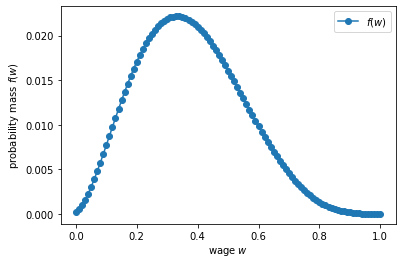

In [2]:
# define the wage offer distribution
B = 1                                         # maximum wage offer
n = 100                                       # number of grid points
w_grid = np.linspace(0,B,n+1)
a, b = 3,5                                   # parameters of the BetaBinomial distribution
f = sp.betabinom(n,a,b)                       # BetaBinomial distribution object
f_grid = f.pmf(np.arange(0,n+1))              # probability mass function
F_grid = f.cdf(np.arange(0,n+1))              # cumulative distribution function

# plot the wage offer distribution
fig, ax = plt.subplots()                                   # define plot
ax.plot(w_grid, f_grid, '-o', label='$f(w)$')              # plot the probability mass function
ax.set(xlabel='wage $w$',ylabel='probability mass $f(w)$') # describe axes
ax.legend()                                                # include legend
plt.show()                                                 # publish graph

Next define the function that solves the Bellman equation.

In [3]:
def mccall_model(w_grid,V0,f,c,β,num_iter=5,err_tol=1e-10,max_iter = 10000):
    # solves the McCall model on a given grid, initial guess V0,
    # discrete density of the wage offer distribution f defined on the grid,
    # unemployment compensation c, and time preference parameter β
    # store first num_iter of the value function iterations, and iterate until precision is reached or
    # max_iter is reached
    
    V_iter = np.zeros(len(w_grid)*num_iter)   # define the matrix that stores first num_iter iterates
    V_iter.shape=(len(w_grid),num_iter)
    V = np.zeros(len(w_grid))                 # define the vector for the value function
    
    V_a = w_grid/(1-β)                        # value of accepting
    V_next = np.empty_like(V_a)               # define an empty vector for the next iterate
    V_cur = V0                                # current iterate
    i = 0
    err = err_tol + 1
    while i < max_iter and err > err_tol:     # iterate until tolerance or maximum iterations are reached
        Q = c+β*sum(V_cur*f)                  # value of rejecting the offer
        V_next = np.maximum(V_a,Q)            # optimal current period decision
    
        if i < num_iter:                      # store first num_iter iterates
            V_iter[:,i]=V_cur

        err = np.max(np.abs(V_next-V_cur))    # compute distance between V_cur and V_next
        V_cur[:] = V_next
        i = i + 1
        
    V[:] = V_next                             # store fixed point
    wbar = (1-β)*Q                            # store reservation wage
    return V,wbar,V_iter

Note that here we never used interpolation at any step in the procedure. Why? 

With this function defined, we can call it$\ldots$

In [4]:
# structural parameters of the model
c = 0.4 * B*a/(a+b)                    # unemployment benefits equal 40% of average wage
β = 0.98                               # time preference
# other parameters for computation
err_tol = 1e-10
num_iter = 6
# initial guess
V0 = np.zeros(n+1)

# run value function iteration
V,wbar,V_iter = mccall_model(w_grid=w_grid,V0=V0,f=f_grid,c=c,β=β,num_iter=num_iter,err_tol=err_tol)

$\dots$ and produce a plot of the value function.

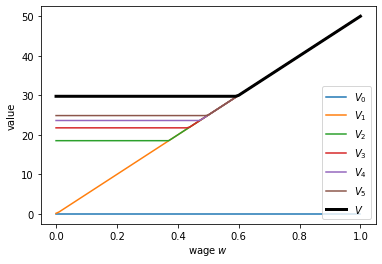

Reservation wage 0.5950616387771832.


In [5]:
fig, ax = plt.subplots()                          # define plot
for i in range(num_iter):                         # plot iterates
    ax.plot(w_grid,V_iter[:,i], label=f'$V_{i}$')

ax.plot(w_grid,V, 'k',label=f'$V$',linewidth=3)   # plot fixed point
ax.set(xlabel='wage $w$',ylabel='value')          # describe axes
ax.legend(loc='lower right')                      # display legend
plt.show()                                        # show plot
print(f'Reservation wage {wbar}.')

## Characterization of the solution

The plot above displays a couple of first iterates $V_n(w)$ and then the value function $V(w)$. We imposed $V_0(w) = 0$, and the sequence of value function iterates $V_n$ is increasing. Consequently, the sequence of the reservation wage iterates is increasing as well.

As an alternative, try adding ${B/(1-\beta)}$ to the initial guess ${V0}$ above, and observe how the sequence of value function iterates evolves now.

## Comparative statics

We can now run the function repeatedly in order to produce comparative statics for the reservation wage. In particular, we are interested in comparative statics in the time-preference parameter and in the mean-preserving spread of the wage offer distribution, modeled as increases in the variance of the wage offer distribution, holding the mean of the wage offer distribution unchanged.

We choose a grid of values for $\beta$. As for the mean-preserving spread, we notice that scaling the wage offer distribution parameters $a,b$ by the same factor $s$ leaves $E[w]$ unchanged but scales the variance. In particular,

$$E[w;n,sa,sb,B] = E[w;n,a,b,B]$$

and

$$Var[w;n,sa,sb,B] = \frac{s(a+b)+n}{a+b+n}\frac{a+b+1}{s(a+b)+1} Var[w;n,a,b,B].$$

Hence we choose a grid for $s$, and then for every value of $s$, we compute the variance of the wage offer distribution. Then, for every pair of $\beta$ and $s$, we resolve the model and record the reservation wage.

In [6]:
β_grid_size = 20
s_grid_size = 30
wbar_grid = np.empty((β_grid_size,s_grid_size))   # array to store recorded wbar values

a, b = 0.3, 0.5
β_vals = np.linspace(0.9,0.99,β_grid_size)        # grid for time preference parameter values
s_vals = np.logspace(0,2,s_grid_size)             # grid for scaling factor values, then recalculate to variances
var_vals = B**2 * (s_vals*(a+b)+n)/n * (a*b)/(a+b)**2/(s_vals*(a+b)+1)

for j,s in enumerate(s_vals):
    f = sp.betabinom(n,s*a,s*b)                   # BetaBinomial distribution object for every new s from the grid
    f_grid = f.pmf(np.arange(0,n+1))              # probability mass function
    for i,β in enumerate(β_vals):
        # resolve the McCall model and record the reservation wage
        V,wbar,V_iter = mccall_model(w_grid=w_grid,V0=V0,f=f_grid,c=c,β=β,num_iter=0,err_tol=err_tol)
        wbar_grid[i,j] = wbar

Finally, plot the calculated values into a fancy contour plot. As expected from the theoretical analysis, the reservation wage increases with the time preference parameter $\beta$, and also increases with the variance of the wage offer distribution.

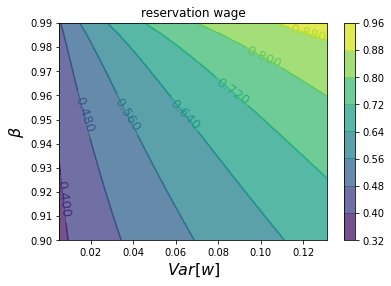

In [7]:
fig, ax = plt.subplots()                                     # define plot

cs1 = ax.contourf(var_vals, β_vals, wbar_grid, alpha=0.75)   # draw color gradient
ctr1 = ax.contour(var_vals, β_vals, wbar_grid)               # draw contours

plt.clabel(ctr1, inline=1, fontsize=13)                      # add values into the contour lines
plt.colorbar(cs1, ax=ax)                                     # add a 'temperature' bar with the color gradient

ax.set_title('reservation wage')                             # add title and describe axes
ax.set_xlabel("$Var[w]$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

plt.show()                                                   # display graph

## Extensions to Value Function Iteration
Value function iteration is a pretty flexible framework. Consider the following problem and can be used to solve several 'intractible' problems by changing the state. This comes down to 'finding the state is an art'.

We use the same environment from section 22 of QuantEcon to start.

Here, we wonder if we really need to evaluate the value function at each iteration. The answer turns out to be no by a clever manipulation of the problem.

Let us define $h$ the **continuation value** as:

$$
h
\doteq c + \beta
    \sum_{s'} v^*(s') q (s')
$$
We can then rewrite the problem from before: 

$$V\left( w\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta} ,c+\beta \int_{0}^{B}V\left( w^{\prime }\right)
dF\left( w^{\prime }\right) \right\} .$$

as 
$$ 
v^*(s')
= \max \left\{ \frac{w(s')}{1 - \beta}, \, h \right\}
$$

Plugging this into the definition of $h$ we get: 

$$
h
= c + \beta
    \sum_{s'}
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s')
$$

Now note that this is a nonlinear equation where we just need to solve for continuation value $h$. Remember that fundamentally what we care about is solving for the reservation wage and that 
$$
\bar{w}=(1-\beta)h
$$ 
so if we find $h$ we are done without computing the value function.


The VFI algorithm is now as follows:

1. Pick an initial guess $h$
2. Update $h_{n}$ to $h_{n+1}$ via backwards induction on the Bellman equation.
3. Iterate until convergence when $|h_{n+1}-h_{n}|<tol$ 

Again by the contraction mapping theorem, we can show that this process will always converge to a unique $h^{*}$. Note that now, we don't need a grid, as we are iterating on a single number rather than a vector.

We implement this below. 

In [8]:
def simplified_mccall_model(w_grid,h0,f,c,β,err_tol=1e-10,max_iter = 10000):
    # solves the McCall model on a given grid, initial guess V0,
    # discrete density of the wage offer distribution f defined on the grid,
    # unemployment compensation c, and time preference parameter β
    # store first num_iter of the value function iterations, and iterate until precision is reached or
    # max_iter is reached
    
    h = h0                                    # initial value of h
    V_a = w_grid/(1-β)                        # value of accepting
    h_iter = np.zeros(num_iter)
    h= np.sum(w_grid*f)/(1-β)
    h_next = np.empty_like(h)

    i = 0
    err = err_tol + 1
    while i < max_iter and err > err_tol:     # iterate until tolerance or maximum iterations are reached   
        s= np.maximum(w_grid/(1-β),h)                          
        h_next= c+β*np.sum(s*f)            # next period value of h.
        err = np.max(np.abs(h_next-h))    # compute distance between V_cur and V_next
        h = h_next
        i = i + 1
    h = h_next
    wbar = (1-β)*h                            # store reservation wage
    return h,wbar

Now we print

In [9]:
import time 

start_full=time.time() # records starting time 
V,wbar_full,V_iter = mccall_model(w_grid=w_grid,V0=V0,f=f_grid,c=c,β=β,num_iter=num_iter,err_tol=err_tol)
elapsed_full = time.time()-start_full # returns elapsed time
print('value of full: {}'.format(wbar_full))
print('Full took {} to run'.format(elapsed_full))


start_simplified=time.time() # records starting time 
h,wbar=simplified_mccall_model(w_grid=w_grid,h0=np.zeros(1),f=f_grid,c=c,β=β)
elapsed = time.time()-start_simplified # returns elapsed time
print(wbar)
start_simplified=time.time()
h,wbar=simplified_mccall_model(w_grid=w_grid,h0=0,f=f_grid,c=c,β=β)
elapsed = time.time()-start_simplified
print('value of simplified: {}'.format(wbar))
print('Simplified took {} to run'.format(elapsed))




value of full: 0.472182913827715
Full took 0.0007238388061523438 to run
0.4721829138267586
value of simplified: 0.4721829138267586
Simplified took 0.004209041595458984 to run


Surprisingly the simplified version runs slower slightly. Why? Most likely `np.maximum` is the problem. Not much gain in this problem.

Consider the following harder problem:

## Persistant Wages
### Environment 
Wages at each point in time are now given by

$$
w_t = \exp(z_t) + y_t
$$

where

$$
y_t \sim \exp(\mu + s \zeta_t)
\quad \text{and} \quad
z_{t+1} = d + \rho z_t + \sigma \epsilon_{t+1}
$$

Here $ \{y_t\} $ is a transitory component and $ \{z_t\} $ is persistent.

We assume $ \{ \zeta_t \} $ and $ \{ \epsilon_t \} $ are distributed as IID standard normals.



As before, the worker can either

1. accept an offer and work permanently at that wage, or  
2. take unemployment compensation $ c $ and wait till next period.  



The value function satisfies the following Bellman equation

$$
v^*(w, z) =
    \max
    \left\{
        \frac{u(w)}{1-\beta}, u(c) + \beta \, \mathbb E[ v^*(w', z')\mid z]
    \right\}
$$


This immediately seems frustrating to solve because we need to calculate the expectation with respect to $w'$ and $z'$. 

### Applying the trick

We can simplify this using the trick from before! Let $f$ be the continuation value defined by:

$$
f^*(z) \doteq u(c) + \beta \, \mathbb E_z v^*(w', z')
$$

The Bellman equation can now be written

$$
v^*(w, z) = \max \left\{ \frac{u(w)}{1-\beta}, \, f^*(z) \right\}
$$

Combining the last two expressions, we see that the continuation value
function satisfies

$$
f^*(z) = u(c) + \beta \, \mathbb {E}_z \max \left\{ \frac{u(w')}{1-\beta}, f^*(z') \right\}
$$

We’ll solve this functional equation for $f^*$ by introducing the
operator

$$
Qf(z) = u(c) + \beta \, \mathbb E_z \max \left\{ \frac{u(w')}{1-\beta}, f(z') \right\}
$$

By construction, $ f^* $ is a fixed point of $ Q $, e.g. 
$ Q f^* = f^* $.

We can then show similar to in class that $Q$ is a contraction mapping. 

### Reservation Wage

Now, as before we look for the reservation wage or the point where
$$
\frac{u(\bar{w})}{1-\beta} = f^{*}(z)
$$
or:

$$ 
\bar{w} =u^{-1}((1-\beta) f^{*}(z))
$$

We assume that $u$ is injective so that it has a well defined inverse. We will also assume that it is the log function so that 
$$ 
\bar{w} =\exp((1-\beta) f^{*}(z))
$$

We take now solve this below. We use monte carlo integration to solve the expectation.

In [10]:
## Parameters ##
μ=0.0       # transient shock log mean
s=1.0       # transient shock log variance
d=0.0       # shift coefficient of persistent state
ρ=0.9       # correlation coefficient of persistent state
σ=0.1       # state volatility
β=0.98      # discount factor
c=5         # unemployment compensation
mc_size = 1000 # number of samples for monte carlo integration
grid_size = 100

## Set up the grid
z_mean = d/(1-ρ)
z_sd = np.sqrt(σ / (1 - ρ**2))
k = 3  # std devs from mean
a, b = z_mean - k * z_sd, z_mean + k * z_sd
z_grid = np.linspace(a, b, grid_size)
# Draw and store shocks
np.random.seed(1234)
e_draws = np.random.randn(2, mc_size)



Next we define the Q operator as a function :



In [11]:
!pip install interpolation # installs interpolation library
from interpolation import interp
from numba import jit 

@jit # speeds up code substantially by compiling to C++ and vectorizing automatically
def Q(c,f_in, f_out):
  """
  Applies the Q operator, where f_in is f_in and f_out is an array representing Qf
  """
  M = mc_size
  for i in range(len(z_grid)):
    z= z_grid[i] # takes element of grid
    expectation = 0.0
    for m in range(M): # number of monte carlo draws
        e1, e2 = e_draws[:, m] # draws for shock to z and y
        z_next = d + ρ * z + σ * e1
        go_val = interp(z_grid, f_in, z_next)        # f(z') on grid
        y_next = np.exp(μ + s * e2)                  # y' draw
        w_next = np.exp(z_next) + y_next             # w' draw
        stop_val = np.log(w_next) / (1 - β)
        expectation += max(stop_val, go_val) # whether the agent decides to stop searching or draw again.
        # Remember expectation of max here.
    expectation = expectation / M # average over draws to 'integrate' at each grid point
    f_out[i] = np.log(c) + β * expectation

Now we compute the fixed point of Q


In [12]:

@jit
def compute_fixed_point(c=c,tol=1e-4,
                        max_iter=1000,):
  f_init = f_init = np.full(len(z_grid), np.log(c)) # fills z_grid with np.log(c)
  f_out = np.empty_like(f_init)

  # Set up loop
  f_in = f_init
  i = 0
  error = tol + 1
# loop evaluating Q 
  while i < max_iter and error > tol:
      Q(c,f_in, f_out) # note we do not need to return anything.
      error = np.max(np.abs(f_in - f_out))
      i += 1
      f_in[:] = f_out
  return f_out

In [13]:
f_star = compute_fixed_point(c)

In [14]:
print(f_star)

[104.0308092  104.04446068 104.05845524 104.07272158 104.08726918
 104.1021053  104.11723178 104.13265618 104.14838678 104.16443193
 104.1808003  104.19750102 104.21454335 104.23193727 104.24969313
 104.2678214  104.28633354 104.30524083 104.32455549 104.34429001
 104.36445753 104.38507212 104.40614838 104.42770205 104.44974976
 104.47230863 104.49539712 104.51903192 104.54322892 104.56804532
 104.59350119 104.61957377 104.64628451 104.67365797 104.70172081
 104.73049998 104.76002207 104.79035648 104.821605   104.85371783
 104.88665286 104.92043451 104.95509336 104.99066714 105.02719917
 105.06473626 105.10338305 105.14332791 105.18455304 105.22694631
 105.27053918 105.31544794 105.3617824  105.40943832 105.45854781
 105.50926166 105.56143904 105.6152054  105.67075958 105.72816475
 105.78721917 105.84795184 105.91039281 105.97471779 106.04109738
 106.10936974 106.17969685 106.25255605 106.32794362 106.40657285
 106.48838284 106.57355419 106.66177397 106.75303413 106.84811572
 106.94761

Now we compute the reservation wage and plot

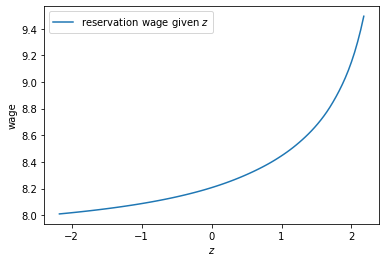

In [15]:
res_wage_function = np.exp(f_star * (1 - β))

fig, ax = plt.subplots()
ax.plot(z_grid, res_wage_function, label="reservation wage given $z$")
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

We can also see how changing unemployment compensation changes the model


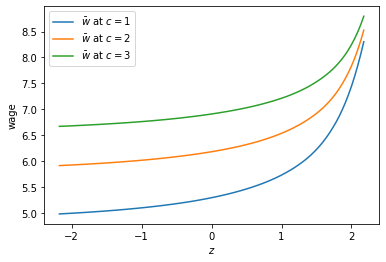

In [16]:
c_vals = 1, 2, 3

fig, ax = plt.subplots()

for c in c_vals:
    c=c # iterates through c values
    f_star = compute_fixed_point(c)
    res_wage_function = np.exp(f_star * (1 - β))
    ax.plot(z_grid, res_wage_function, label=rf"$\bar w$ at $c = {c}$")

ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()